In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
#import seaborn as sns
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() /"data"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def modified_disorder_mean(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1+1 #Bins [0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += arr[:,j,shot]
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = new_arr[:,bin]/counts[bin]
    return new_arr

def modified_disorder_std(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1+1 #Bins [0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    arr_mean = modified_disorder_mean(arr,distance_matrix,bin_length)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff = int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += (arr[:,j,shot]-arr_mean[:,j_eff])**2
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = np.sqrt(new_arr[:,bin]/(counts[bin]*(counts[bin]-1)))
    return new_arr

def count_bins_total(distance_matrix,bin_length):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1+1 #Bins [0,l),[l,2l),...
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff] += 1
    return counts

In [5]:
def bin_data(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins,SHOTS))
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            new_arr[:,j_eff,shot] += arr[:,j,shot]
            counts[j_eff,shot] += 1
        for bin in range(0,n_bins):
            if counts[bin,shot] != 0:
                new_arr[:,bin,shot] = new_arr[:,bin,shot]/counts[bin,shot]
    return new_arr

def count_bins(distance_matrix,bin_length):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1+1 #Bins [0,l),[l,2l),...
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff,shot] += 1
    return counts

In [15]:
folders

[PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.95'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.90'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.85'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.80'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.75'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.70'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.65'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.60'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples_rp/data/noisy_chain_pbc_1.55'),
 PosixPath('/home/qd/Documents/max/OTOCs/notebooks/Work

In [16]:
jobids = []
params = []
data = []
positiondesc = []
positions = []
distance_matrices = []
folders = [datapath/"noisy_chain_pbc_1.{}".format(i) for i in range(95,-5,-5)]
folders[-1] = datapath/"noisy_chain_pbc_1.00"
folders[-2] = datapath/"noisy_chain_pbc_1.05"
folders = folders + [datapath/"noisy_chain_pbc_0.{}".format(i) for i in range(9,4,-1)]
filenames = ["combined_file_ρ{:.2f}.jld2".format(i).replace("0","") for i in np.arange(1.95,0.95,-0.05)]
filenames[-1] = "combined_file_ρ1.0.jld2"
filenames[-2] = "combined_file_ρ1.05.jld2"
filenames = filenames + ["combined_file_ρ0.{}.jld2".format(i) for i in range(9,4,-1)] 
for i in range(len(folders)):
    with h5py.File(folders[i]/filenames[i],"r") as f:

        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]] for l in range(len(f["data"]))]))
        params.append(f["params"][()])
        positiondesc.append([f[f["positiondata"][l]][()][0] for l in range(len(f["positiondata"]))])
        ref_desc = [f[f["positiondata"][l]][()][1] for l in range(len(f["positiondata"]))]
        positions.append(np.array([f[ref_desc[l]][()] for l in range(len(f["positiondata"]))]))
        ref_desc = [f[f["positiondata"][l]][()][2] for l in range(len(f["positiondata"]))]
        distance_matrices.append(np.array([f[ref_desc[l]][()] for l in range(len(f["positiondata"]))]))




        # jobids.append(f["jobid"][()].decode("UTF-8"))
        # data.append(2-2*rearrange_data(np.array(f["data"][()])))
        # params.append(f["params"][()])

        # positiondesc.append(f["positiondata"][()][0])

        # positions.append(np.swapaxes(f[f["positiondata"][()][1]][()],0,1))
        # distance_matrices.append(np.swapaxes(f[f["positiondata"][()][2]][()],0,2))
        # for  i in range(0,len(folders)):
#         data[i] = np.concatenate(data[i],axis=2)
#         positions[i] = np.concatenate(tuple(positions[i][k] for k in range(len(positions[i]))),axis=1)
#         distance_matrices[i] = np.concatenate(tuple(distance_matrices[i][k] for k in range(len(distance_matrices[i]))),axis=2)
for  i in range(0,len(filenames)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
    positions[i] = np.swapaxes(np.concatenate(positions[i],axis=0),0,1)
    distance_matrices[i] = np.swapaxes(np.concatenate(distance_matrices[i],axis=0),0,2)

In [32]:
N = 13
SHOTS = [data[i].shape[2] for i in range(len(filenames))]
T = 10 ** np.linspace(-3,6,100)
T_long = 10 ** np.linspace(-3,10,150)

In [19]:
ls = [2/positiondesc[ds][0][-1]+0.1 for ds in range(len(folders))]
res_m = list(map(lambda arr,distance_matrix,l: modified_disorder_mean(arr,distance_matrix,l), data, distance_matrices, ls))
res_err = list(map(lambda arr,distance_matrix,l: modified_disorder_std(arr,distance_matrix,l), data, distance_matrices, ls))
counts = list(map(lambda distance_matrix,l: count_bins(distance_matrix,l),distance_matrices, ls))
counts_tot = list(map(lambda distance_matrix,l: count_bins_total(distance_matrix,l),distance_matrices, ls))

/tmp/ipykernel_19918/290831554.py:39: RuntimeWarning: invalid value encountered in true_divide
  new_arr[:,bin] = np.sqrt(new_arr[:,bin]/(counts[bin]*(counts[bin]-1)))


In [20]:
#C6 = 400/(2*np.pi) * 1e9 #Hz(μm)^6
#r = 7 #μm

In [21]:
Jm = np.zeros(len(folders))
for ds in range(len(folders)):
    #J = C6*0.25*np.power(r*distance_matrices[ds],-6)[:,:,:]
    J = np.power(distance_matrices[ds],-6)[:,:,:]
    Jm[ds] = np.mean([np.median(J[:,:,i].diagonal(1)) for i in range(0,SHOTS[ds])])
    #print(np.std([np.median(J[:,:,i].diagonal(1)) for i in range(0,50)])/np.sqrt(50))

/tmp/ipykernel_19918/3503803954.py:4: RuntimeWarning: divide by zero encountered in power
  J = np.power(distance_matrices[ds],-6)[:,:,:]


In [22]:
Jm

array([0.87376399, 0.76332672, 0.66475839, 0.5786239 , 0.50503487,
       0.44395964, 0.35803846, 0.30002377, 0.27968388, 0.23051817,
       0.19180777, 0.15221526, 0.1251151 , 0.10729299, 0.09094695,
       0.06800561, 0.05909612, 0.04915436, 0.03713947, 0.02882495,
       0.035329  , 0.022855  , 0.0106919 , 0.00607428, 0.00271989])

In [23]:
np.flatten(counts[10])

AttributeError: module 'numpy' has no attribute 'flatten'

In [24]:
counts_tot[10]

array([ 50.,  66., 106., 102., 110., 105., 104.,   7.])

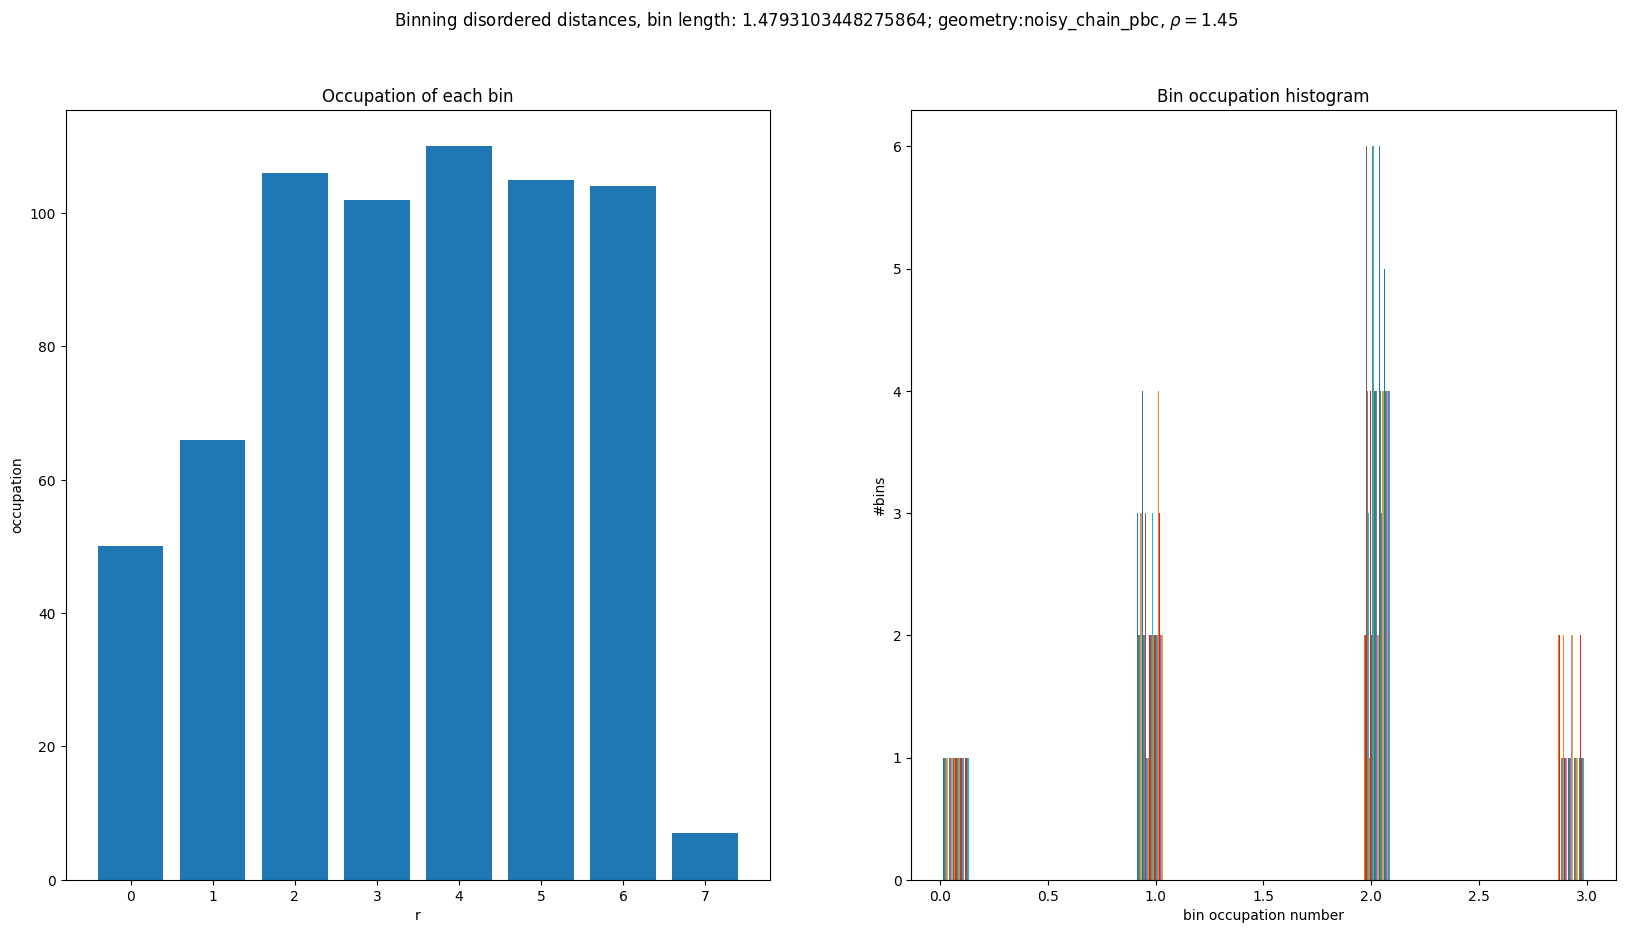

In [25]:
ds=10
bins = [i for i in range(0,len(counts[ds]))]
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[1].hist(counts[ds],20)
axs[1].set_title("Bin occupation histogram")
axs[1].set_xlabel("bin occupation number")
axs[1].set_ylabel("#bins")

axs[0].bar(bins,counts_tot[ds])
axs[0].set_title("Occupation of each bin")
axs[0].set_xlabel("r")
axs[0].set_ylabel("occupation")
plt.suptitle(r"Binning disordered distances, bin length: {}; geometry:{}, $\rho=${}".format(ls[ds],positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
plt.show()


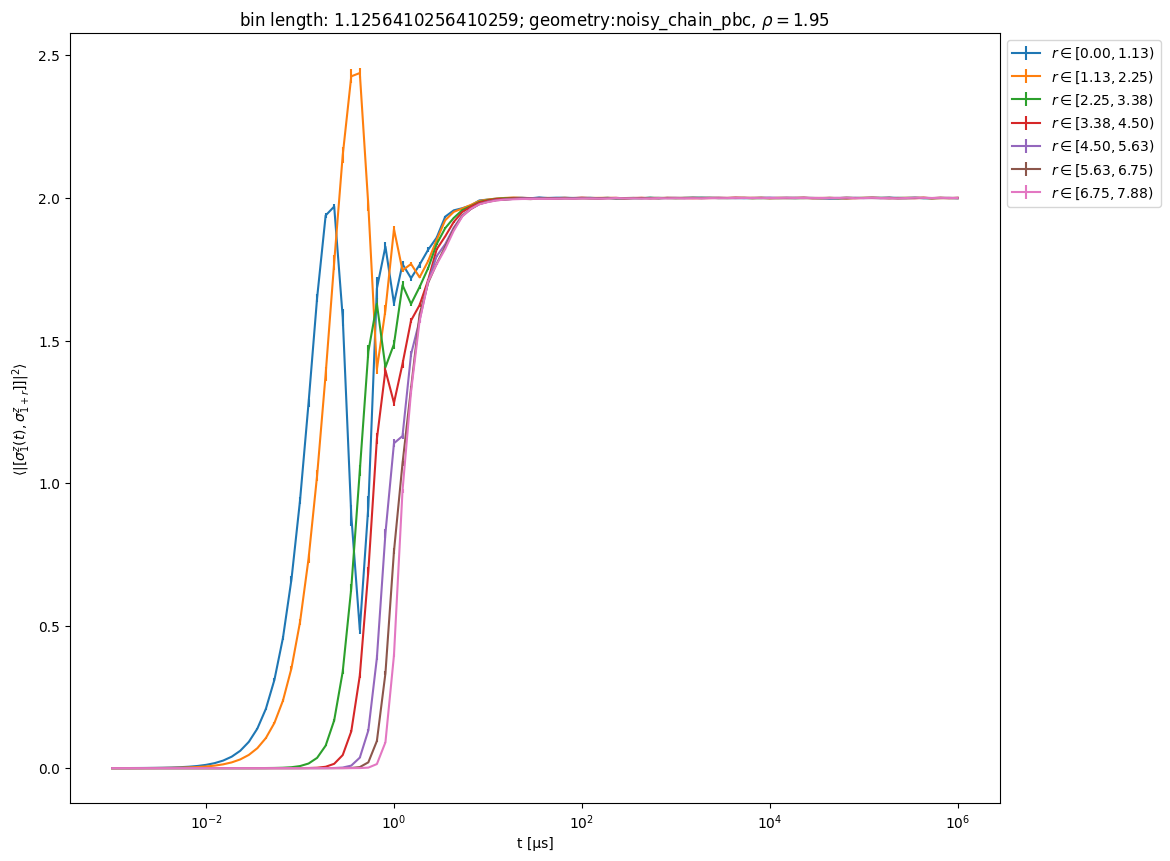

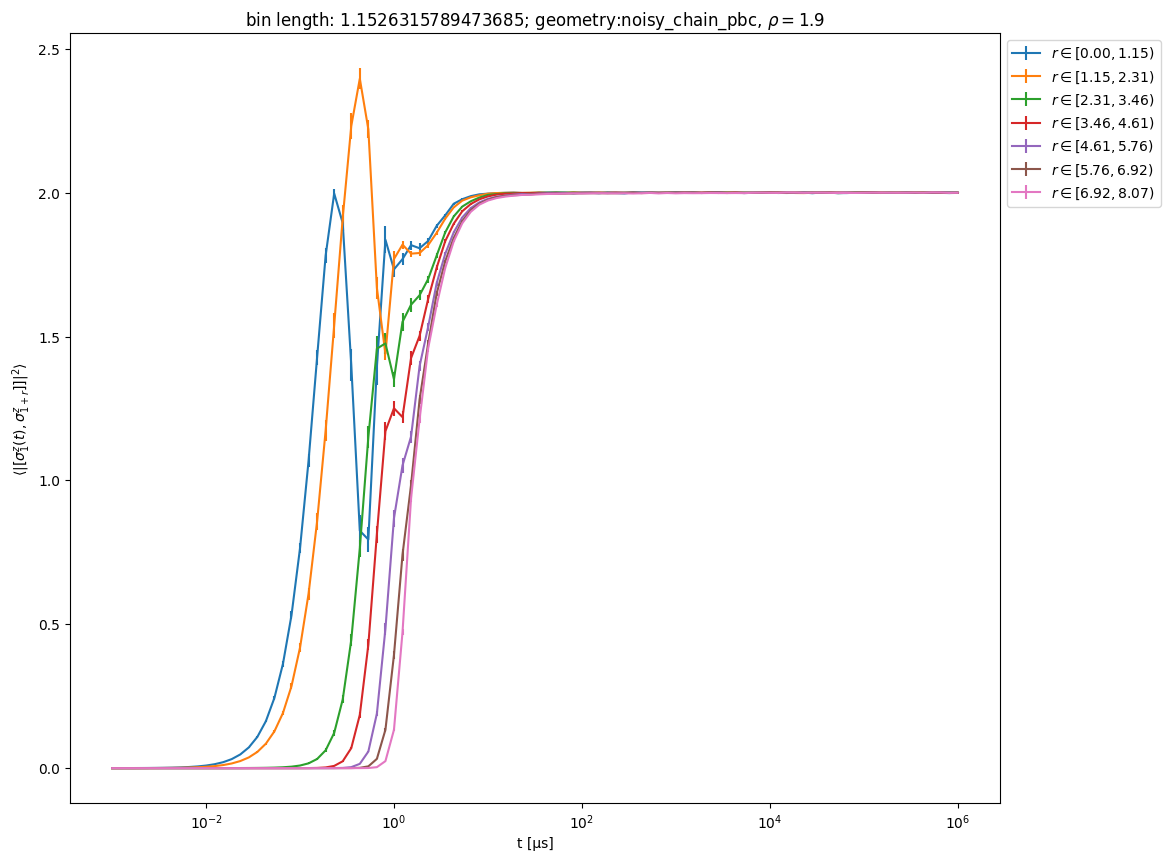

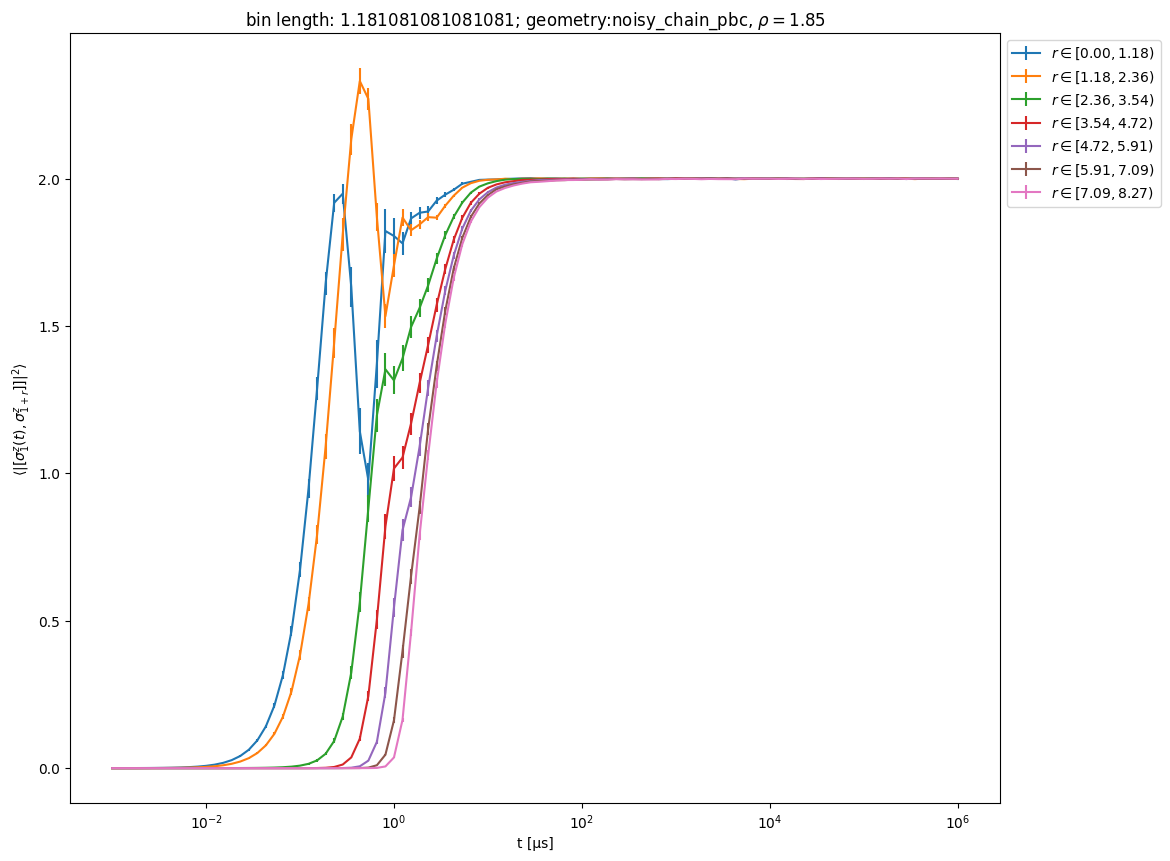

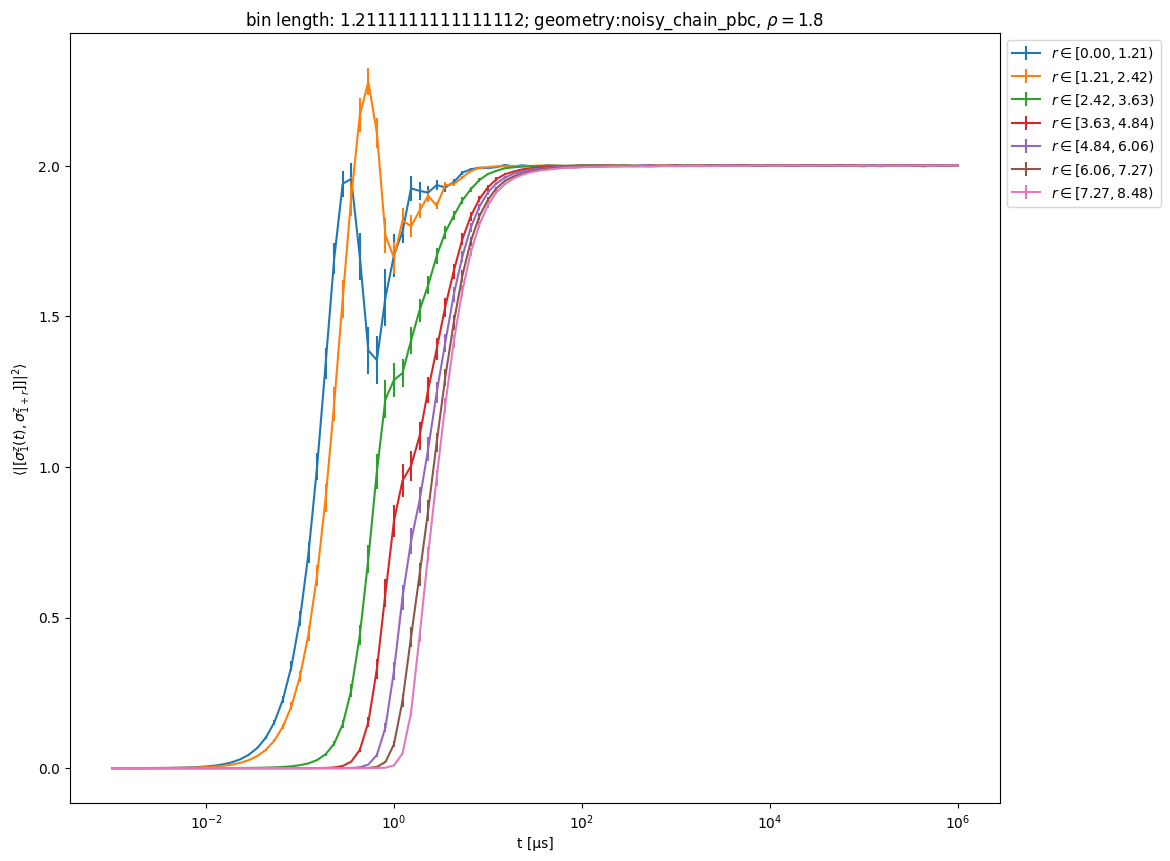

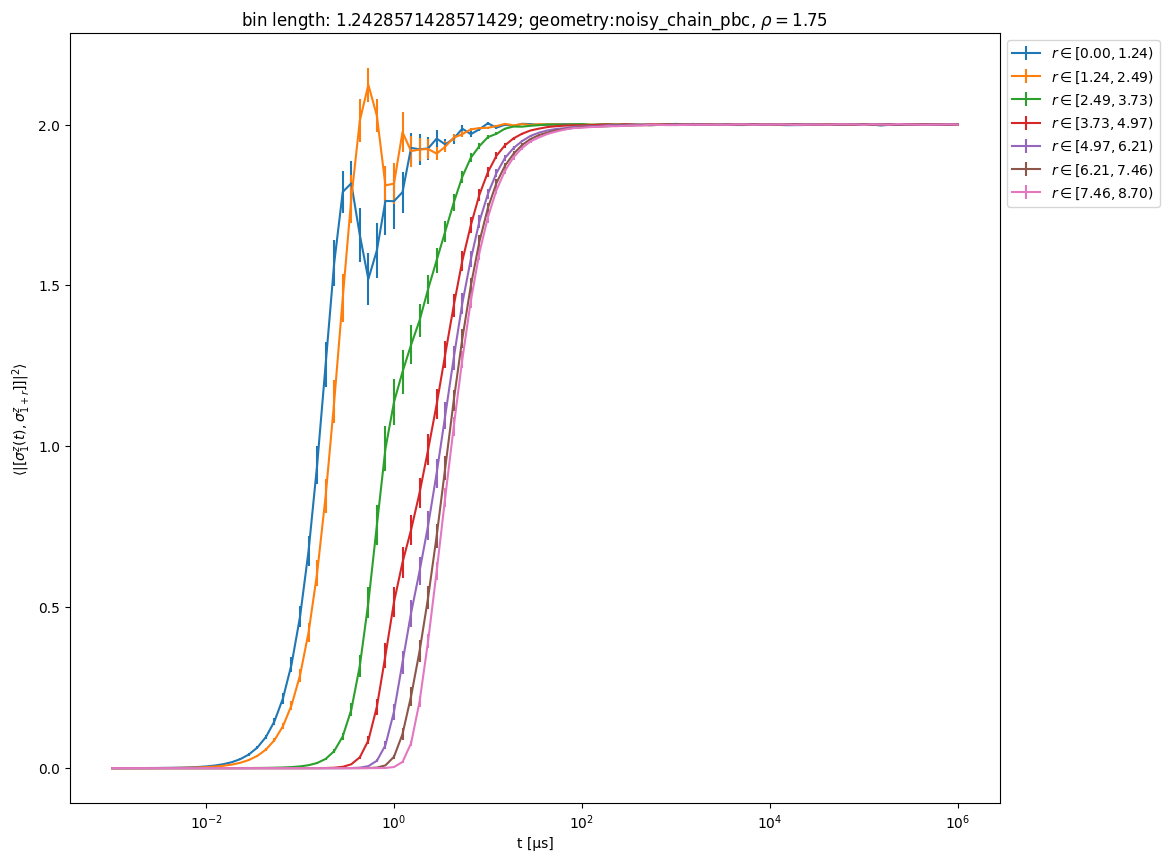

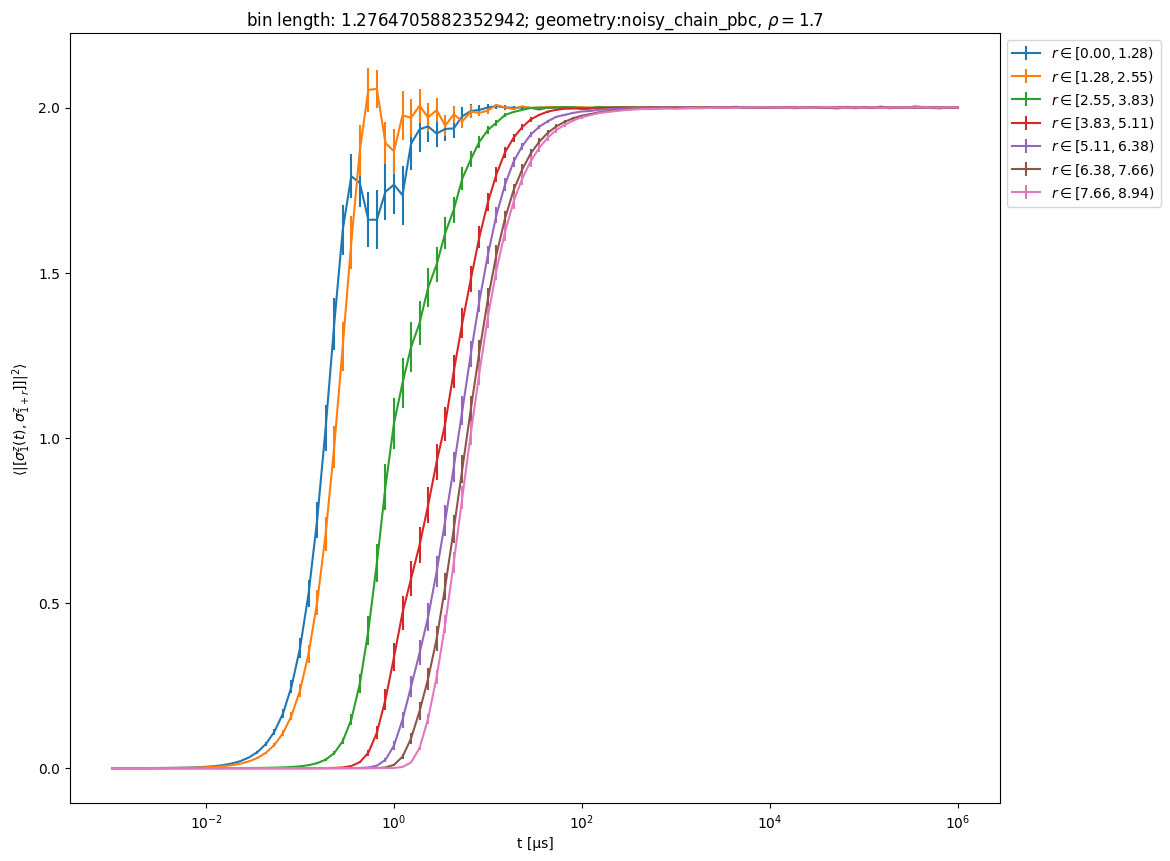

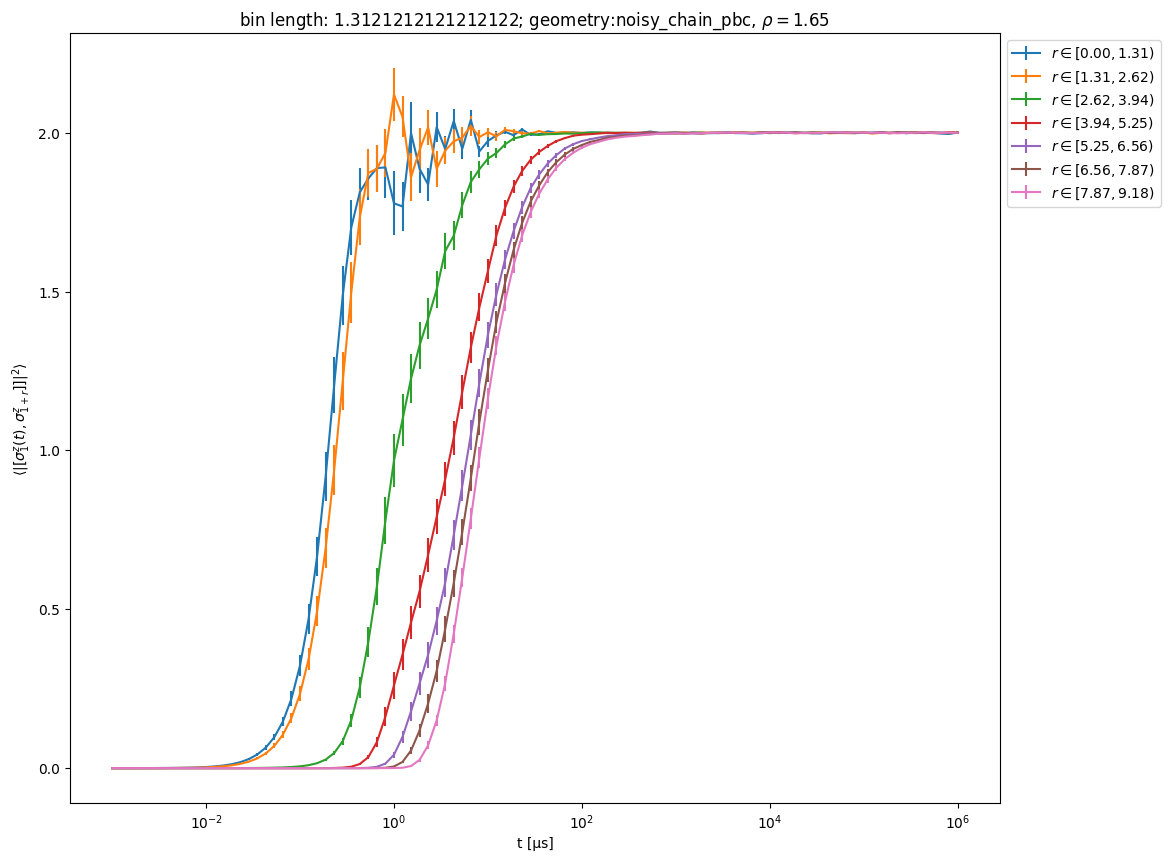

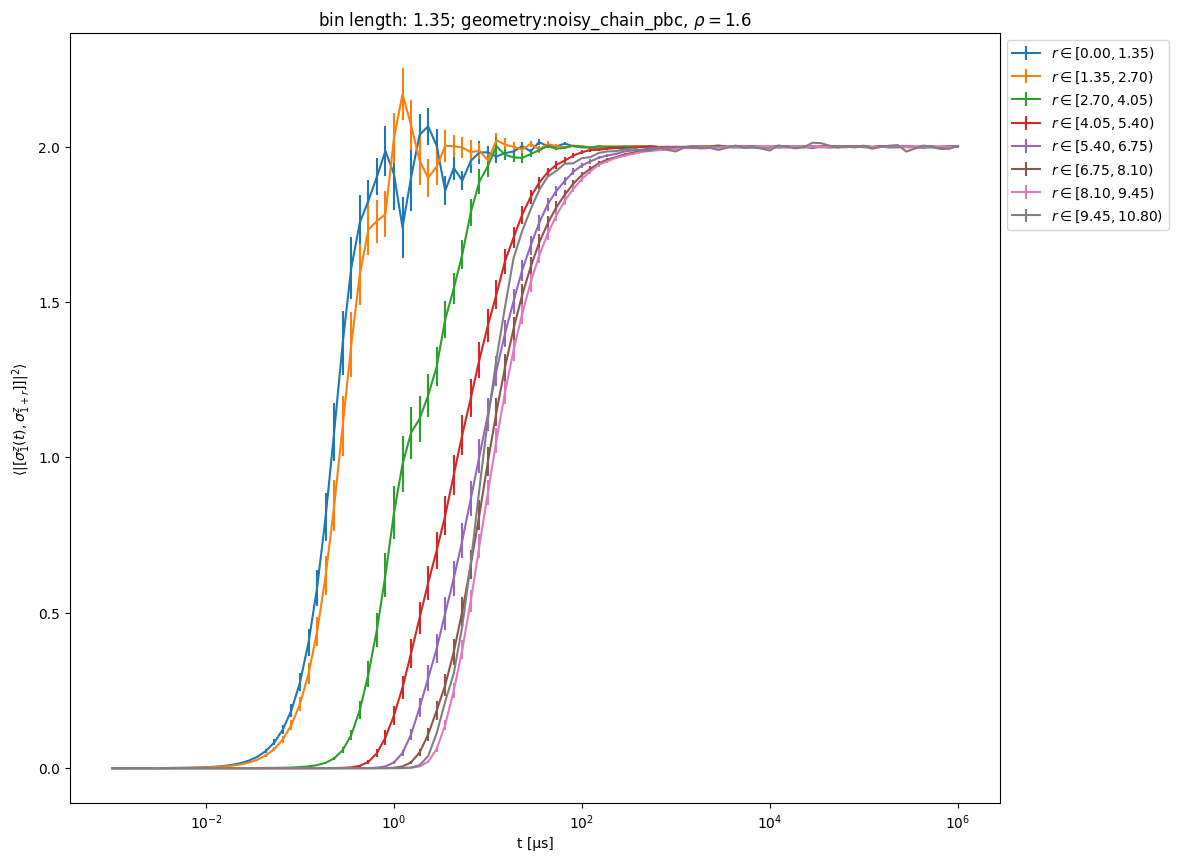

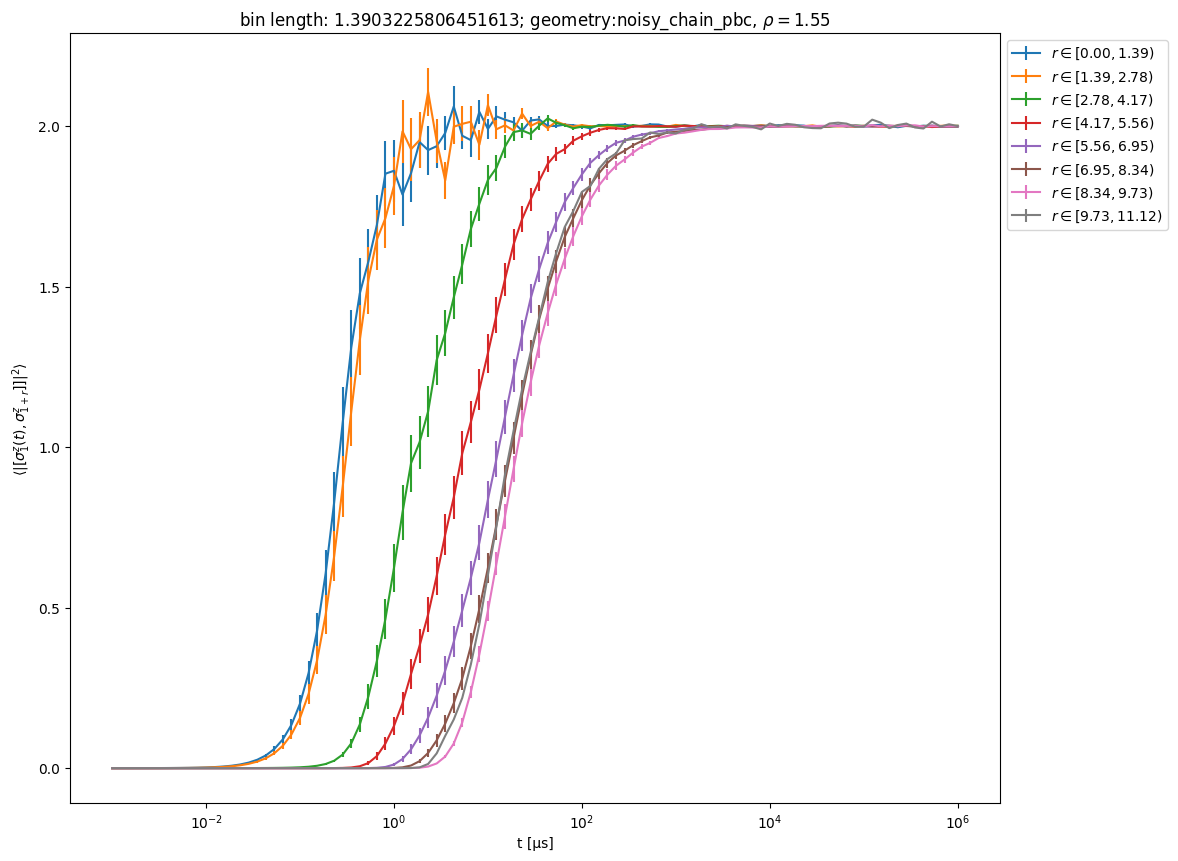

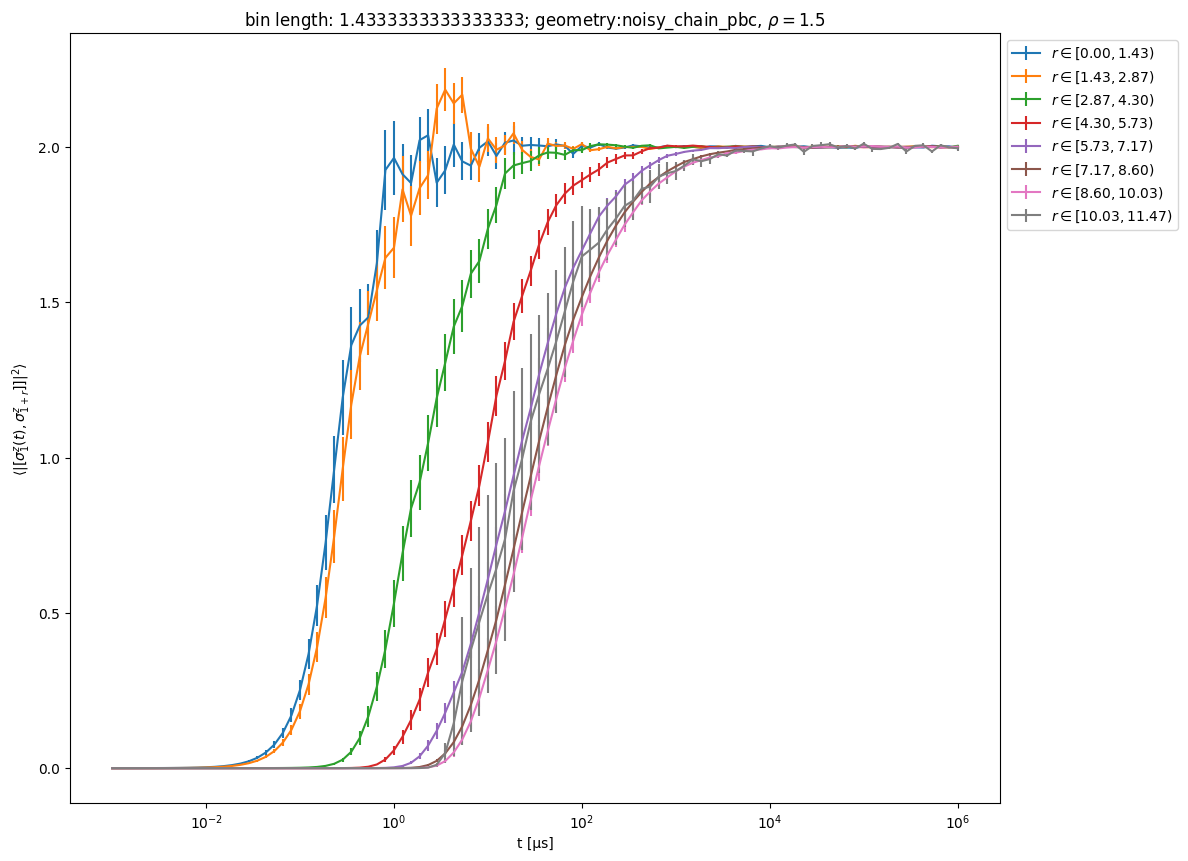

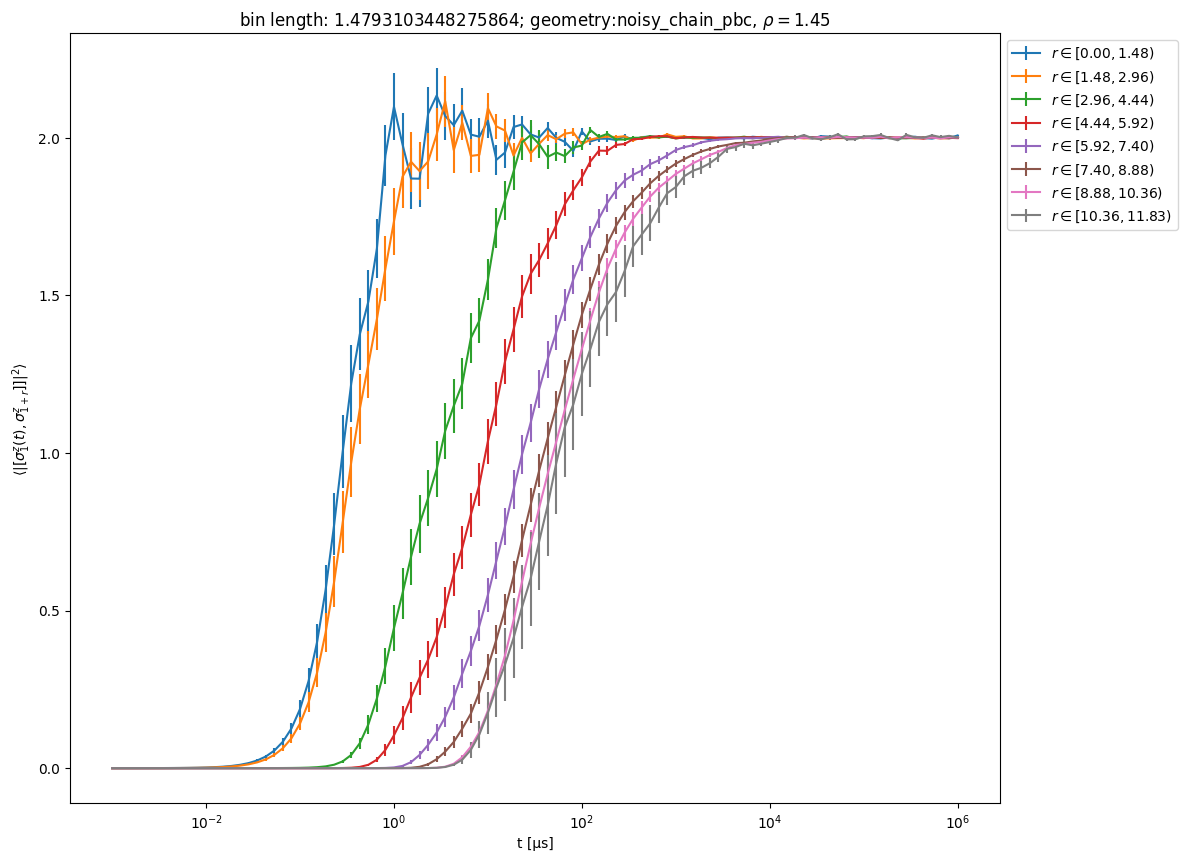

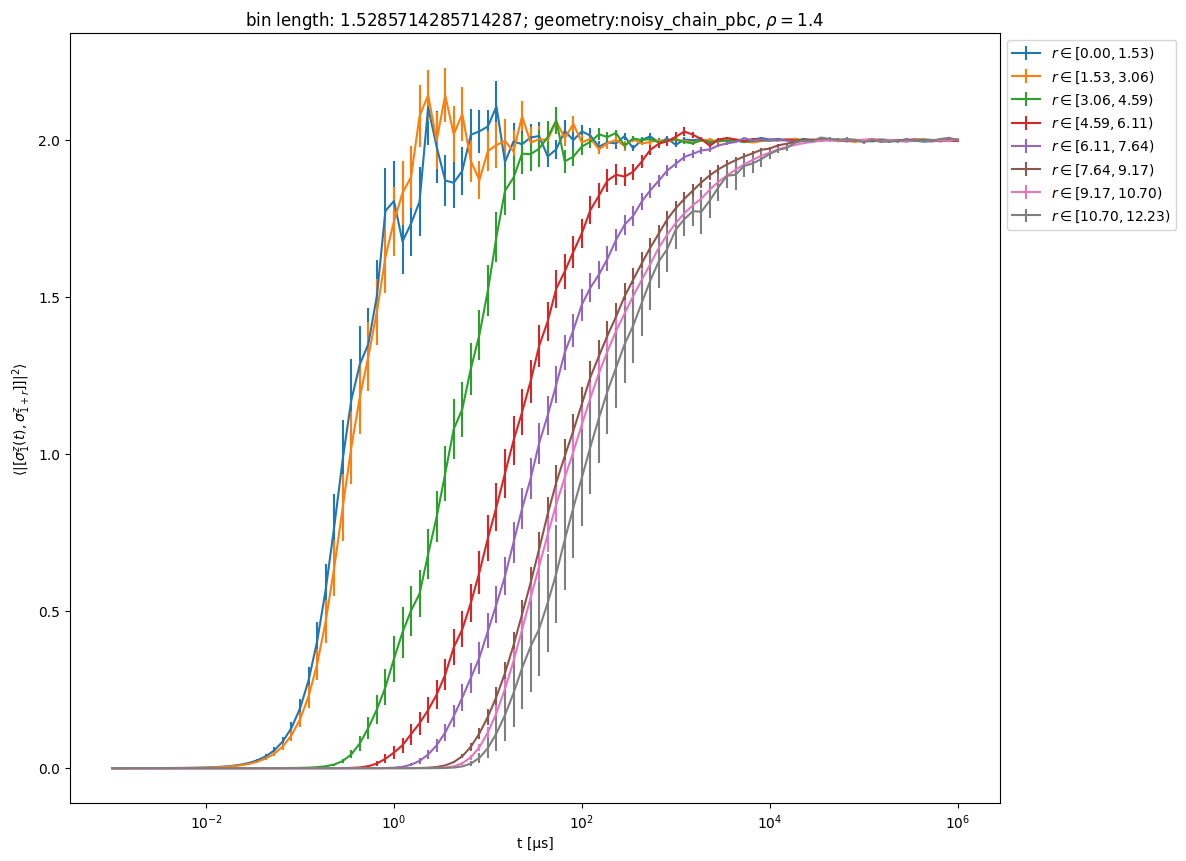

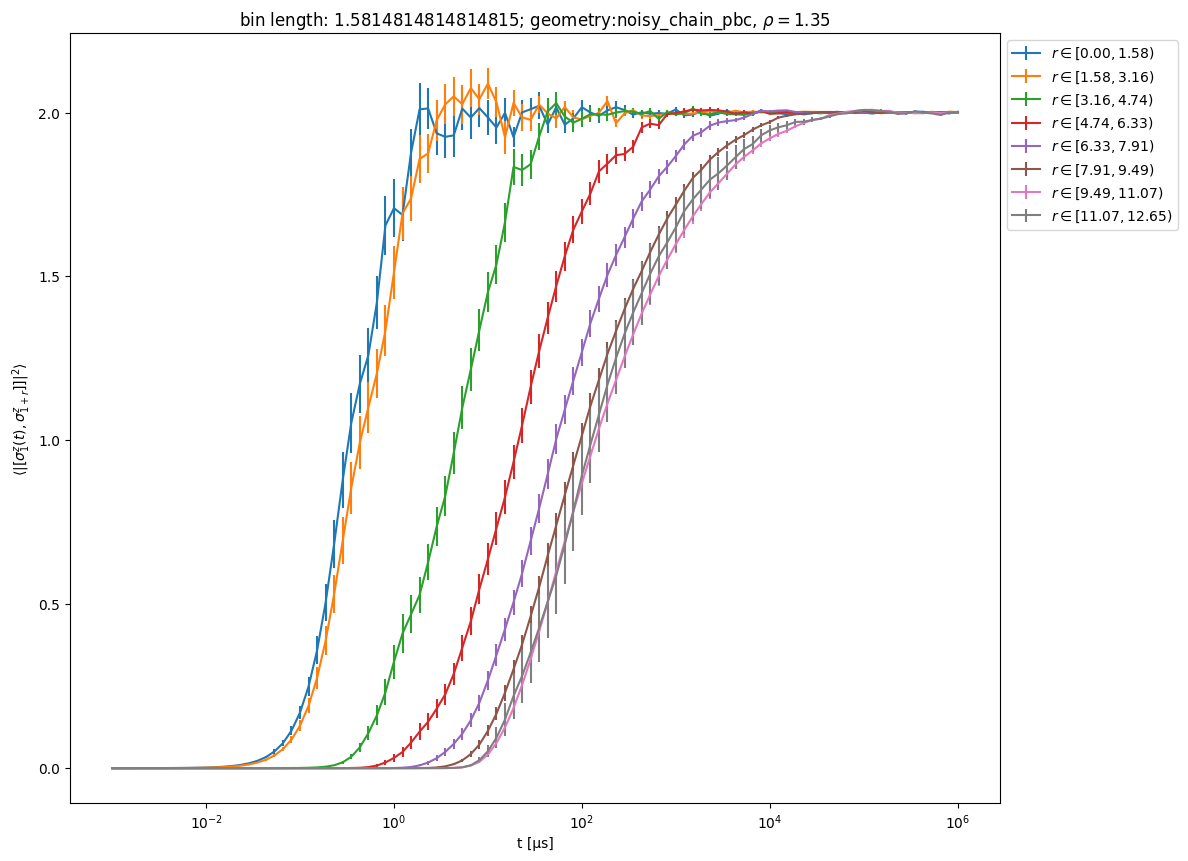

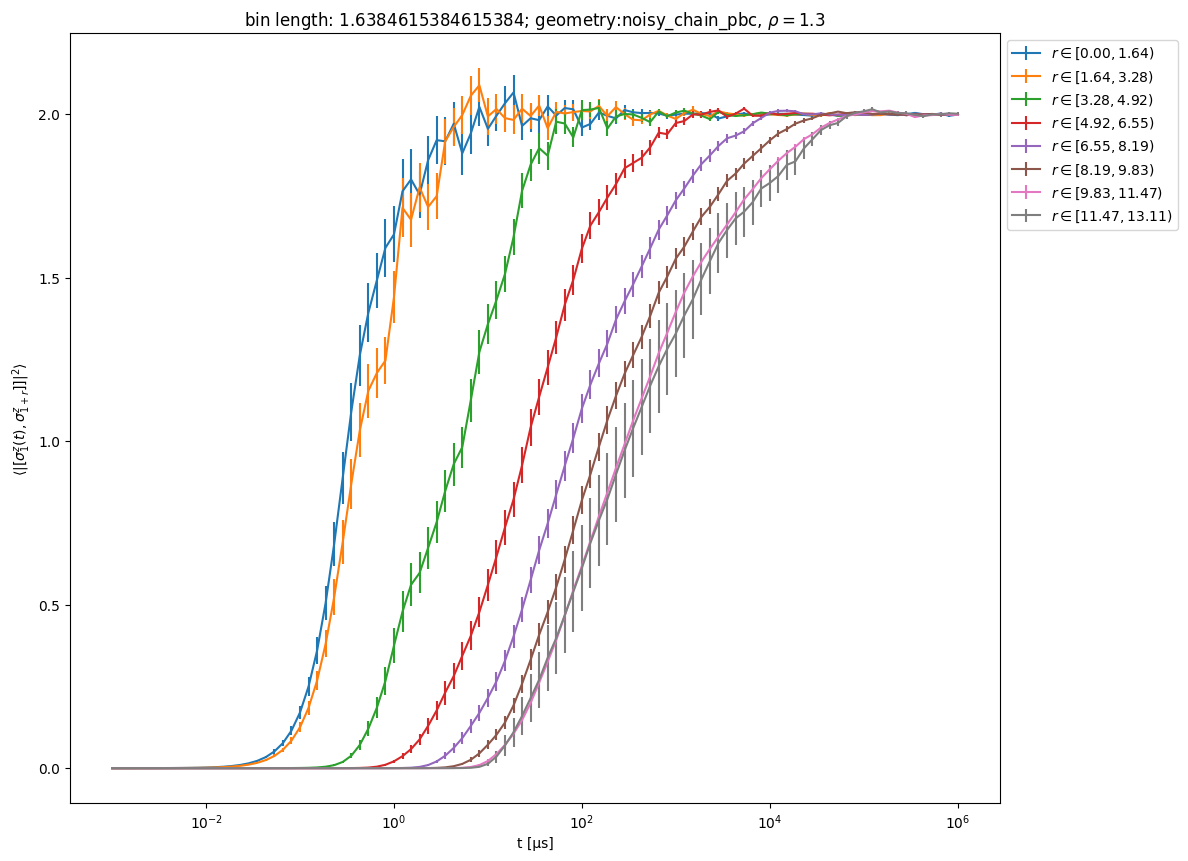

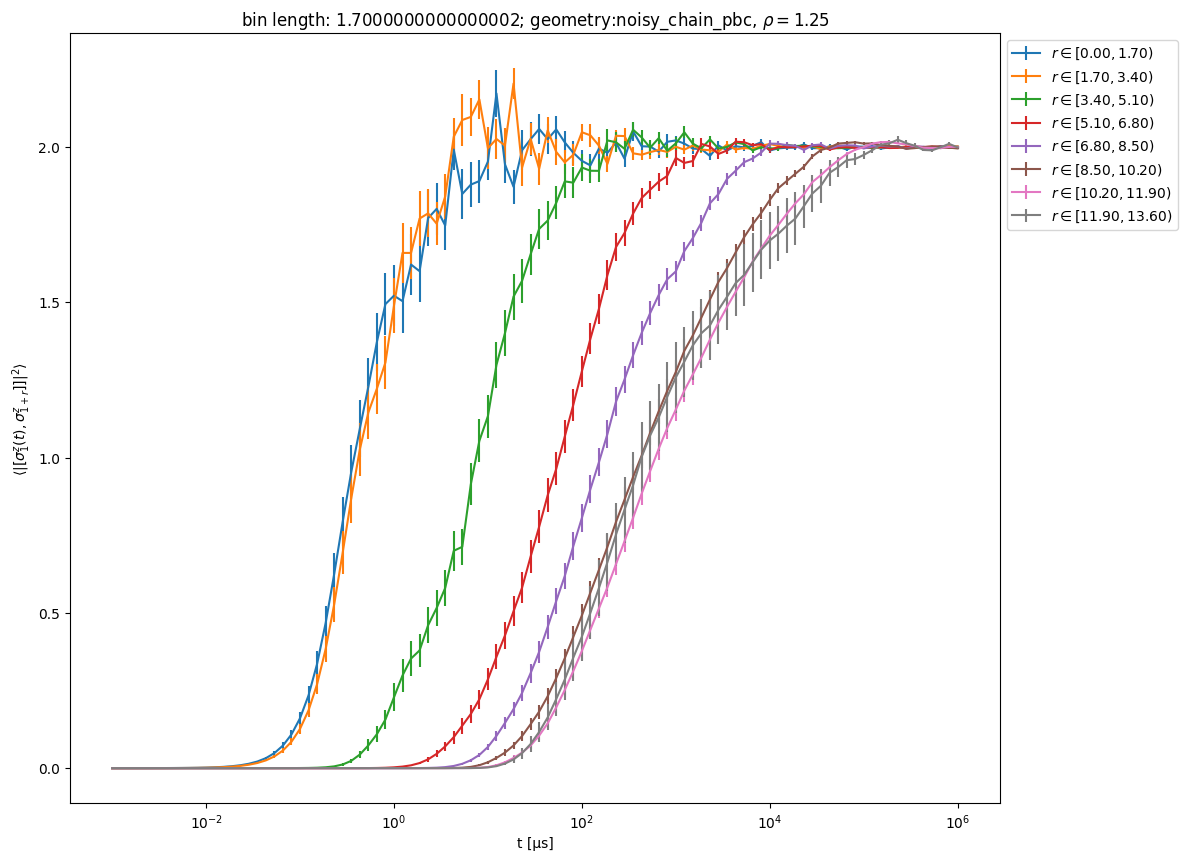

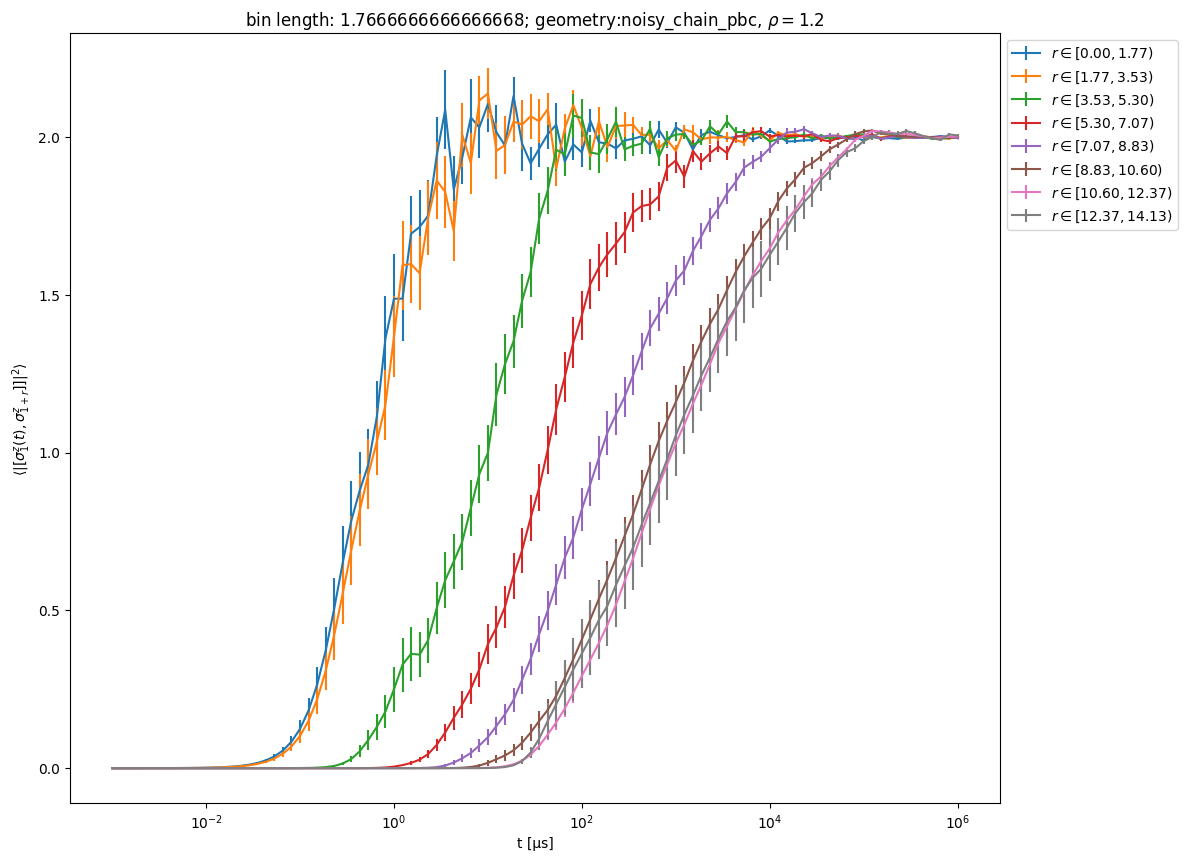

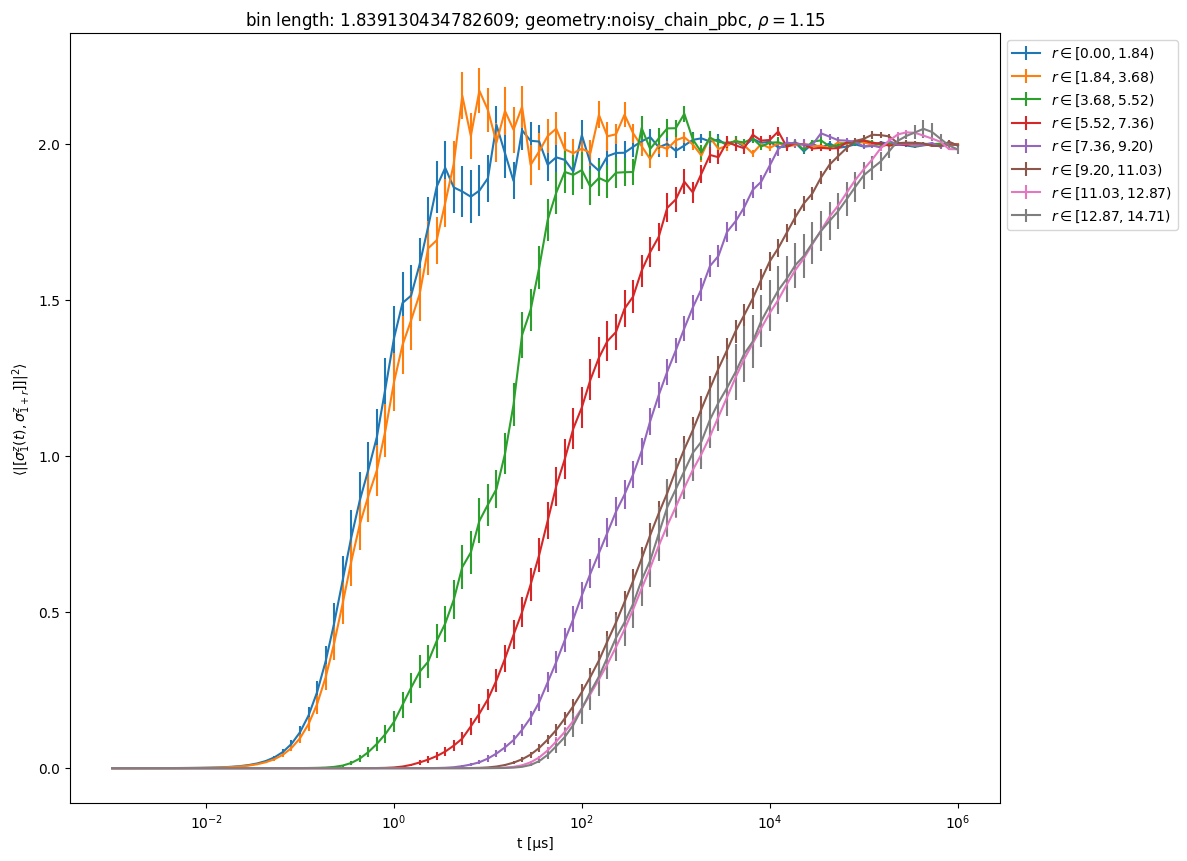

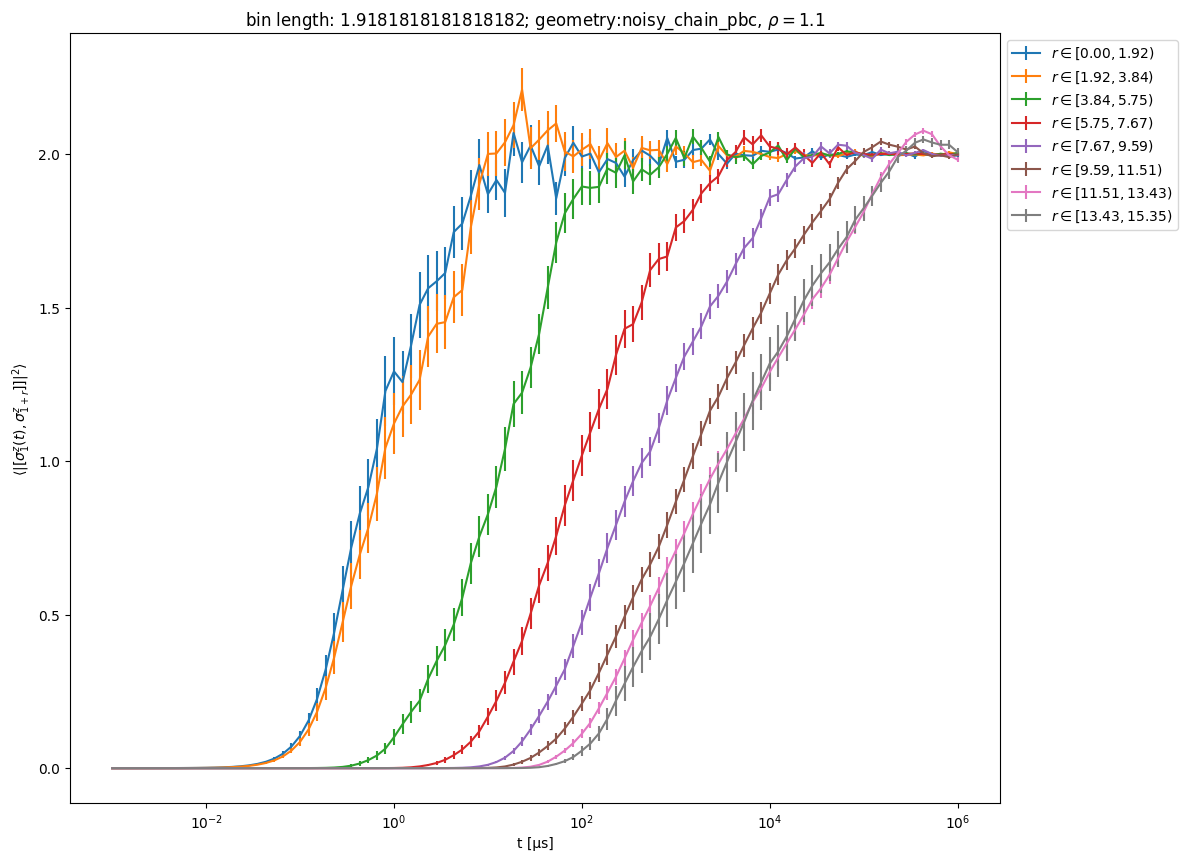

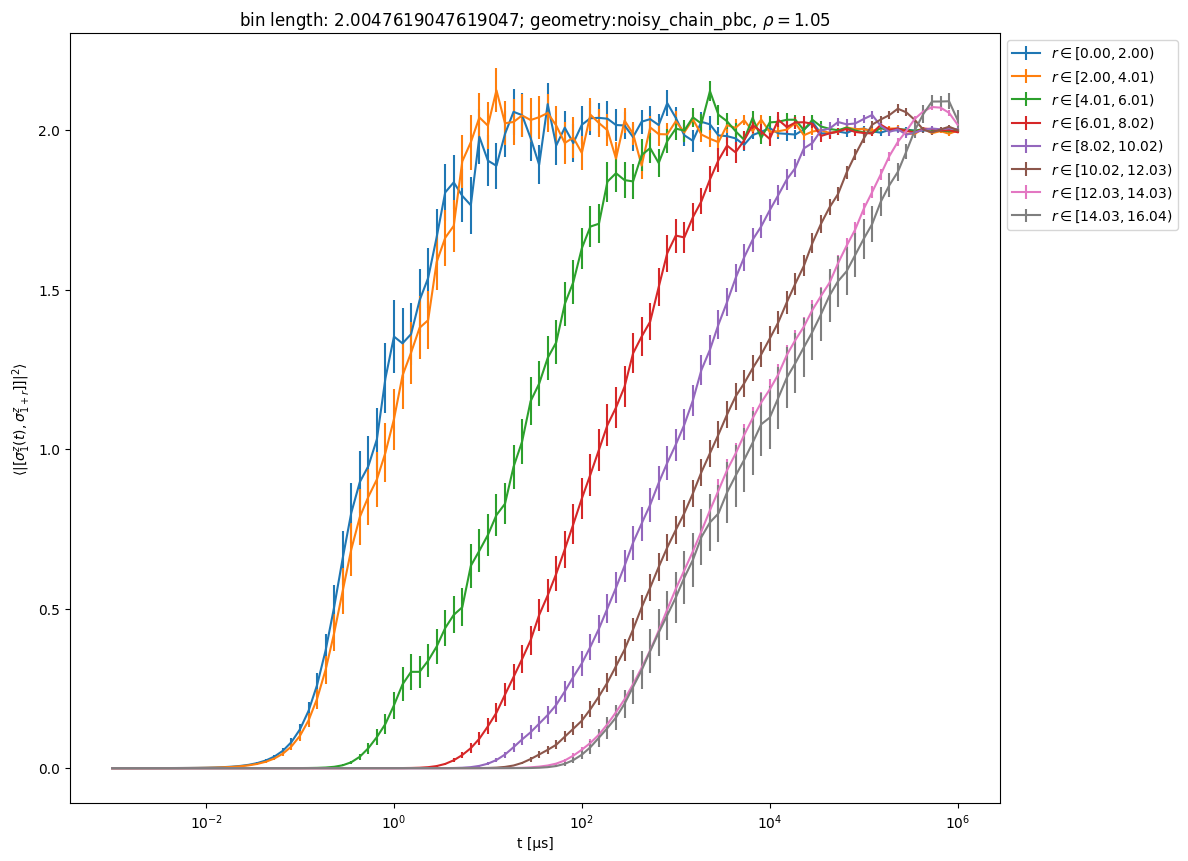

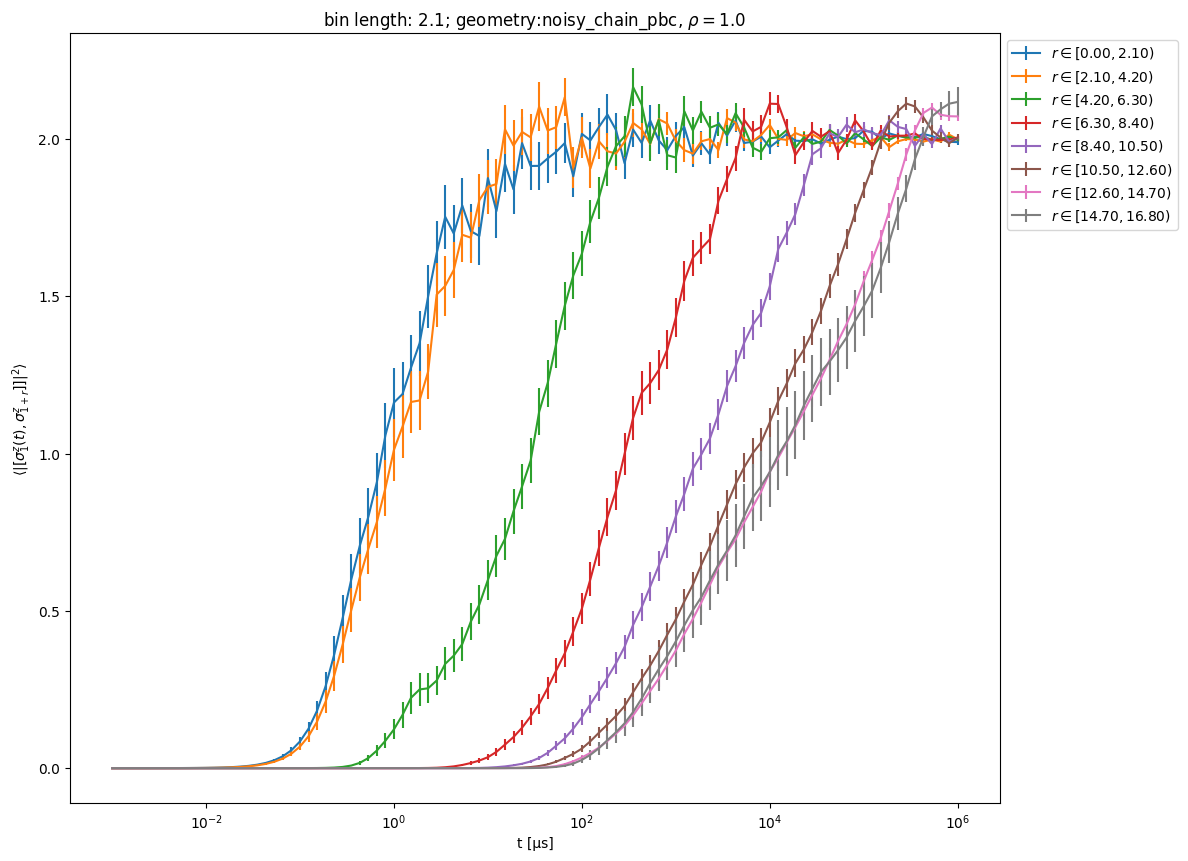

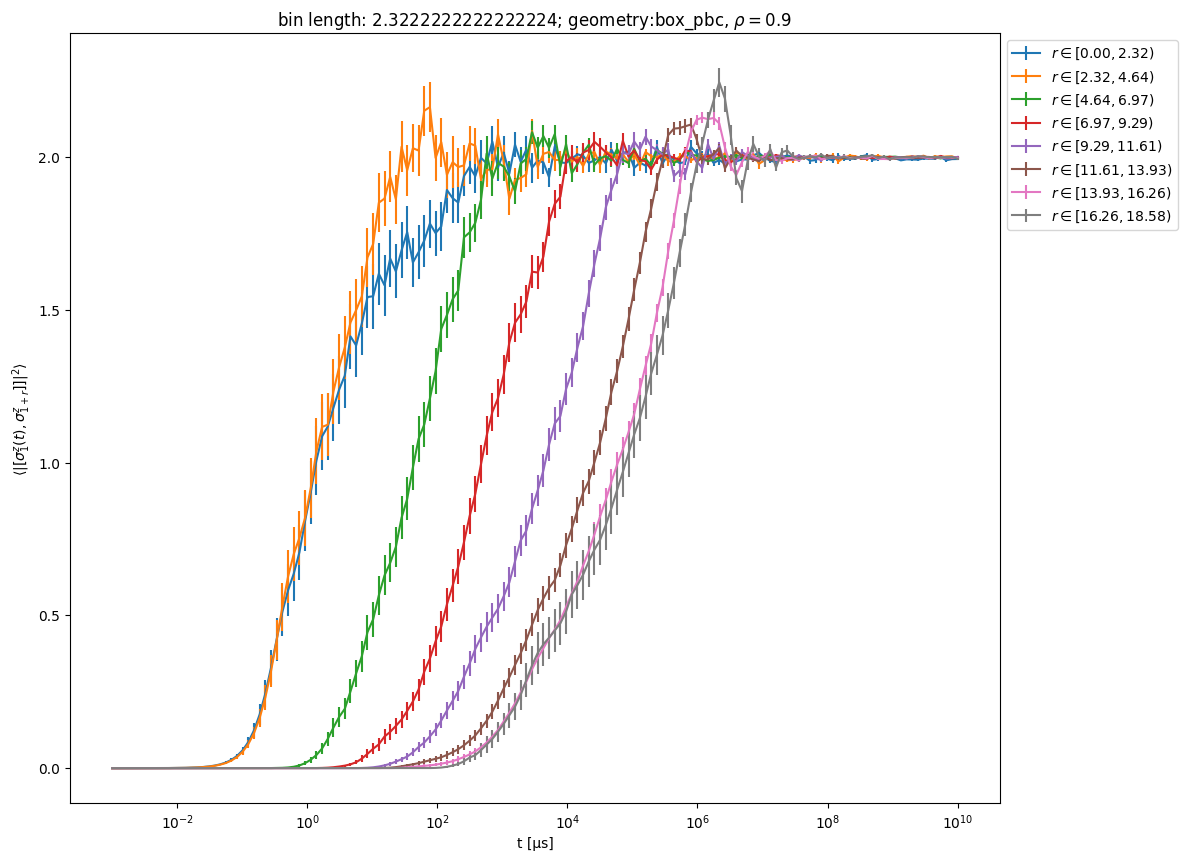

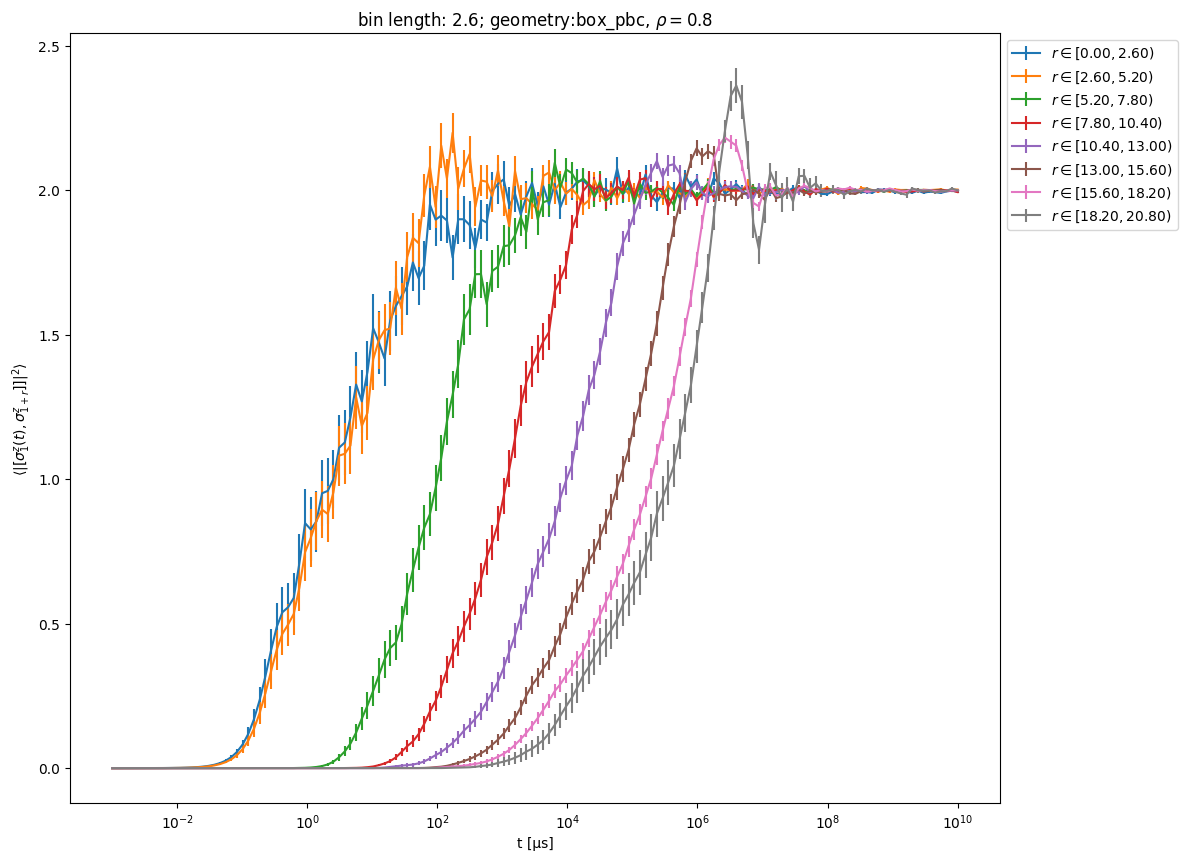

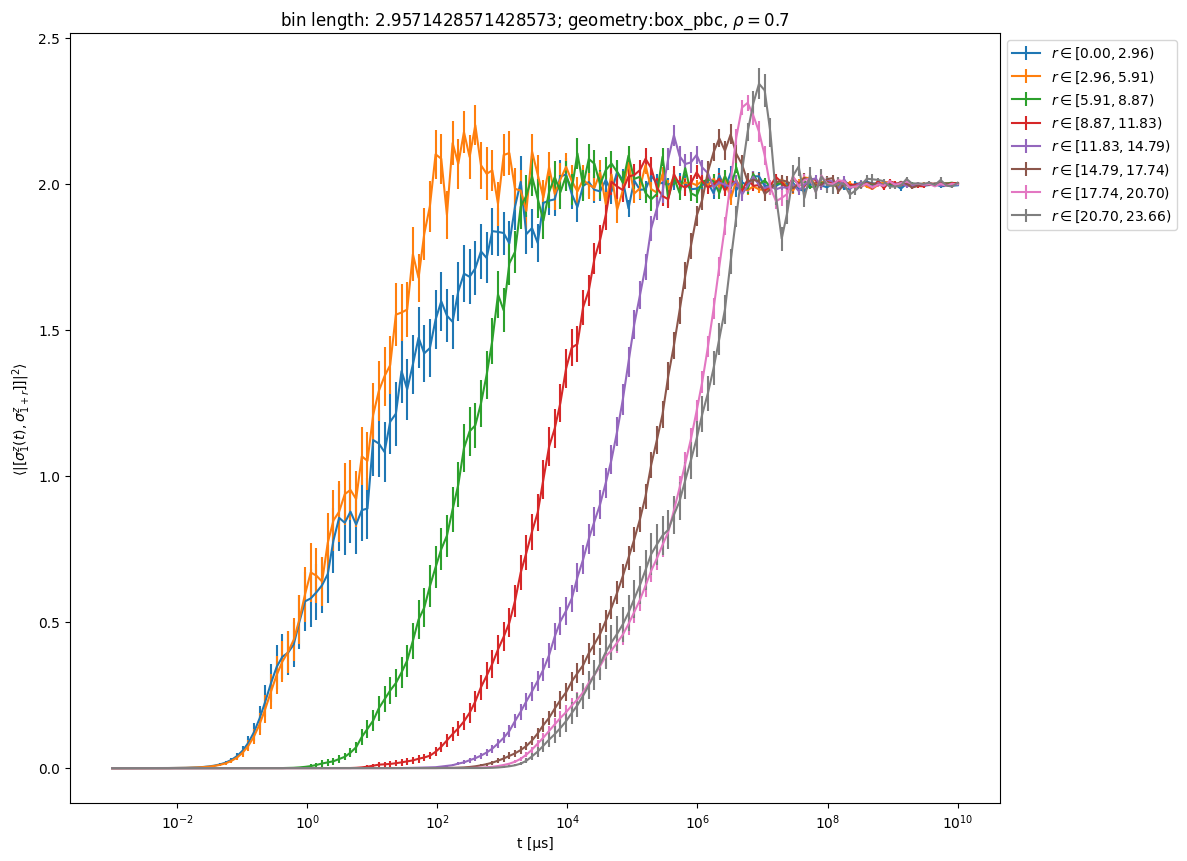

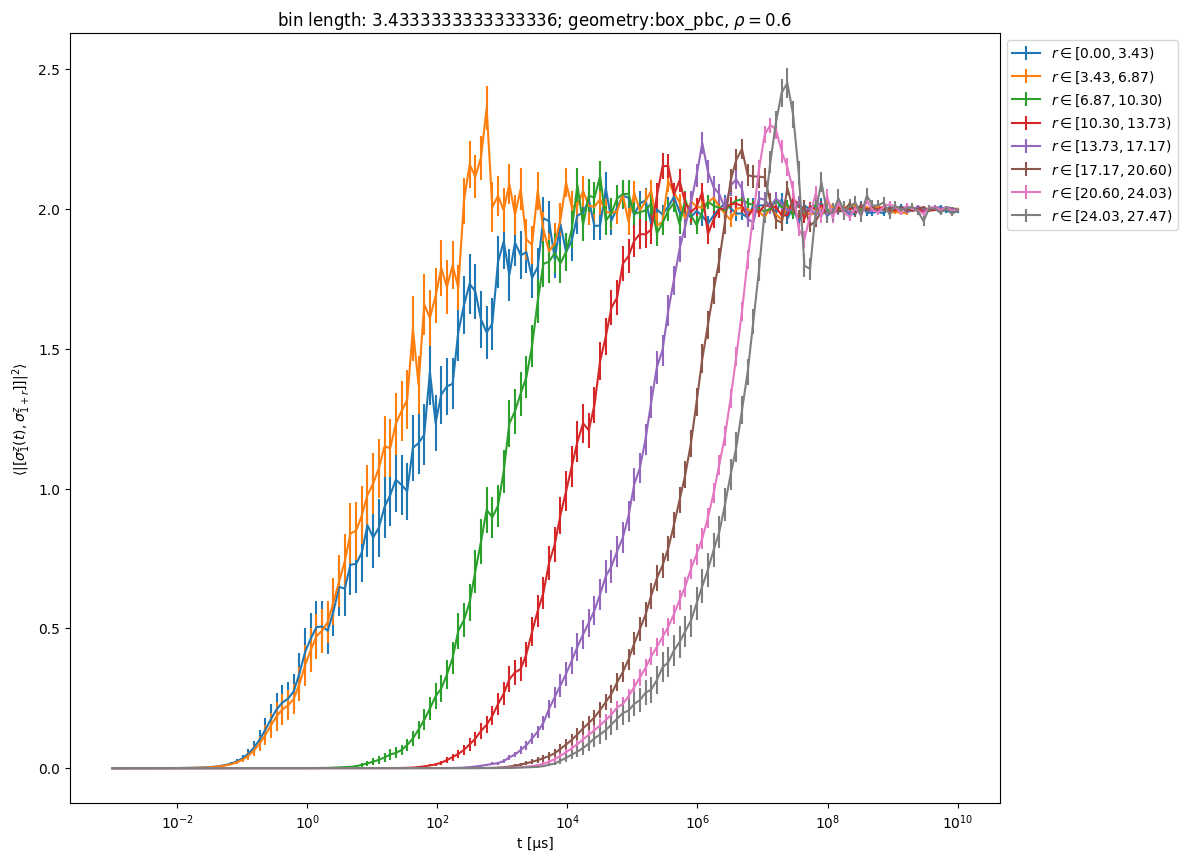

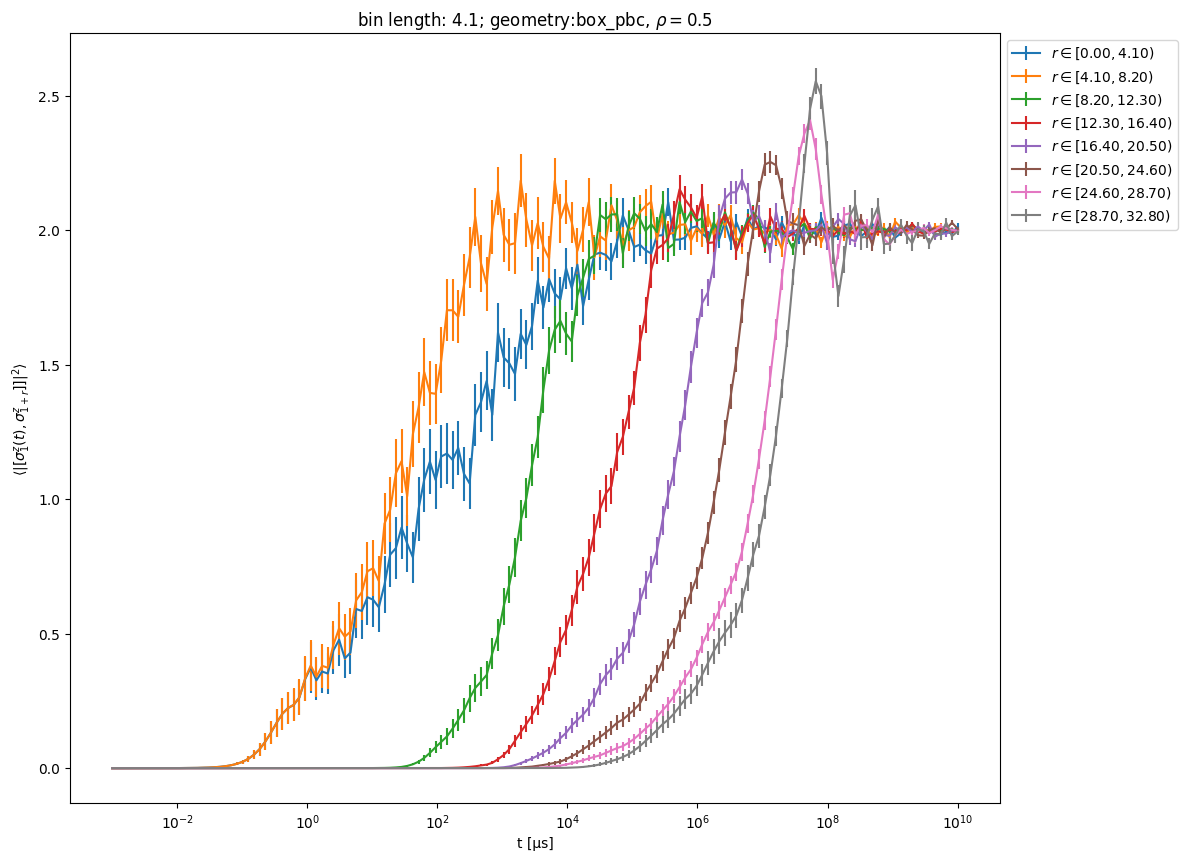

In [37]:
for ds in range(len(folders)):
    bins = [i for i in range(0,len(counts[ds]))]
    plt.figure(figsize=(12,10))
    for j in range(0,len(bins)):
        if res_m[ds].shape[0] == 100:
            plt.errorbar(T,res_m[ds][:,j],res_err[ds][:,j],label=r"$r\in[${:.2f}$,${:.2f}$)$".format(j*ls[ds],(j+1)*ls[ds]))
        else:
            plt.errorbar(T_long,res_m[ds][:,j],res_err[ds][:,j],label=r"$r\in[${:.2f}$,${:.2f}$)$".format(j*ls[ds],(j+1)*ls[ds]))
    plt.legend()
    plt.xscale("log")
    plt.title(r"bin length: {}; geometry:{}, $\rho=${}".format(ls[ds],positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
    plt.xlabel("t [μs]")
    plt.ylabel(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$")
    plt.legend(bbox_to_anchor=(1, 1))
    #plt.xlim(1e0,1e3)
    #plt.yscale("log")
    plt.show()

In [34]:
for ds in range(len(folders)):
    print("rho= {:.2f}, spacing = {:.2f} * blockade radius".format(positiondesc[ds][0][-1],2/positiondesc[ds][0][-1]))

rho= 1.95, spacing = 1.03 * blockade radius
rho= 1.90, spacing = 1.05 * blockade radius
rho= 1.85, spacing = 1.08 * blockade radius
rho= 1.80, spacing = 1.11 * blockade radius
rho= 1.75, spacing = 1.14 * blockade radius
rho= 1.70, spacing = 1.18 * blockade radius
rho= 1.65, spacing = 1.21 * blockade radius
rho= 1.60, spacing = 1.25 * blockade radius
rho= 1.55, spacing = 1.29 * blockade radius
rho= 1.50, spacing = 1.33 * blockade radius
rho= 1.45, spacing = 1.38 * blockade radius
rho= 1.40, spacing = 1.43 * blockade radius
rho= 1.35, spacing = 1.48 * blockade radius
rho= 1.30, spacing = 1.54 * blockade radius
rho= 1.25, spacing = 1.60 * blockade radius
rho= 1.20, spacing = 1.67 * blockade radius
rho= 1.15, spacing = 1.74 * blockade radius
rho= 1.10, spacing = 1.82 * blockade radius
rho= 1.05, spacing = 1.90 * blockade radius
rho= 1.00, spacing = 2.00 * blockade radius
rho= 0.90, spacing = 2.22 * blockade radius
rho= 0.80, spacing = 2.50 * blockade radius
rho= 0.70, spacing = 2.86 * bloc